In [467]:
# Alle notwendigen Import werden Hier gemacht

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json
from pathlib import Path
import json

In [468]:
import math

def cholesky_factorization(a): # A*lambda=b  wobei A=x(mittelpunkt der Bereichen, b=y ( q95 der Laufzeiten jedre Bereich))
    n = len(a)
    l = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1):
            sum_val = sum(l[i][k] * l[j][k] for k in range(j))
            if i == j:
                l[i][j] = math.sqrt(a[i][i] - sum_val)
            else:
                l[i][j] = (a[i][j] - sum_val) / l[j][j]
    return l

def forward_substitution(l, b):
    n = len(b)
    y = [0.0 for _ in range(n)]
    y[0] = b[0] / l[0][0]
    for i in range(1, n):
        sume = sum(l[i][j] * y[j] for j in range(i))
        y[i] = (b[i] - sume) / l[i][i]
    return y

def backward_substitution(lt, y):
    n = len(y)
    x = [0.0 for _ in range(n)]
    x[n - 1] = y[n - 1] / lt[n - 1][n - 1]

    for i in range(n - 2, -1, -1):
        sume = sum(lt[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (y[i] - sume) / lt[i][i]
       
    return x

def solve_linear_equation_system(a, b):
    n = len(b)
    l = cholesky_factorization(a)
    # Transposer L pour avoir L^T
    lt = [[l[j][i] for j in range(n)] for i in range(n)]
    y = forward_substitution(l, b)
    x = backward_substitution(lt, y)
    return x


In [ ]:
# Methode zum Einlesen der Daten und Berechnen der Laufszeiten.

def read_and_compute_runtime(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df

# r1=read_and_compute_runtime("runtimes.mp80")
#print(r1)


In [470]:
#Methode read_and_compute_runtime aufrufen, Laufzeiten, Mittelwerte, Varianz , median und standardabweichungen  von Jede Prozessor berechnen
# und in einem DataFrame (~ Dictionary ) speichern 

files = {
    "Intel N95 (mp80)": "runtimes.mp80",
    "Intel N100": "runtimes.n100",
    "Raspberry Pi 5": "runtimes.pi5"
}

data = {name: read_and_compute_runtime(path) for name, path in files.items()}
#print(data)

results=[]
for name, df in data.items():
    mean = df["runtime_s"].mean()
    median = df["runtime_s"].median()
    var = df["runtime_s"].var()
    std = df["runtime_s"].std()
    max=df["runtime_s"].max()
    min=df["runtime_s"].min()
    
    
    results.append({'Name': name,'Mean': mean,'Median': median,'Varianz': var, 'Standardabweichung': std, 'MinZeit (in Sekunden)': min,'MaxZeit(in Sekunden': max})

# jetz als DataFrame umwandeln
mmvs_df = pd.DataFrame(results)

print(mmvs_df)

               Name      Mean  Median        Varianz  Standardabweichung  \
0  Intel N95 (mp80)   58.5965    44.0    4801.035205           69.289503   
1        Intel N100   43.9185    34.0    2717.963840           52.134095   
2    Raspberry Pi 5  110.0830    67.0  133378.350286          365.210008   

   MinZeit (in Sekunden)  MaxZeit(in Sekunden  
0                    7.0               1538.0  
1                    8.0               1518.0  
2                   10.0              14990.0  


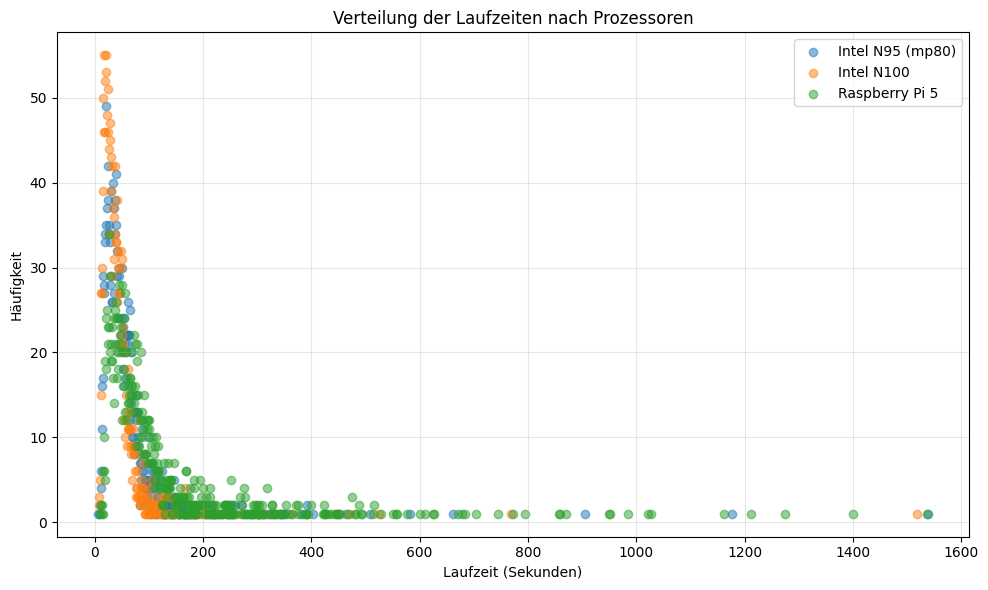

In [471]:
plt.ion()
plt.figure(figsize=(10, 6))

counts_dict = {}
for name, df in data.items():
    
    runtimes_rounded = df["runtime_s"] #.round(1)
    counts = runtimes_rounded.value_counts().sort_index()
    counts_dict[name]=counts
    counts = counts[(counts.index >= 0) & (counts.index <= 2000)]
    counts=counts[(counts.values>=0 )& (counts.values<=250)]
    plt.scatter(counts.index,counts.values , label=name,alpha=0.5)
    #plt.plot(counts.index, counts.values, label=name)
    
plt.xlabel("Laufzeit (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten nach Prozessoren")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.legend()
plt.legend()
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

counts_df=pd.DataFrame(counts_dict); counts_df = counts_df.fillna(0) # Laufzeiten und deren Haufigken in einem DataFrame gespeichert.
#print(counts_df)

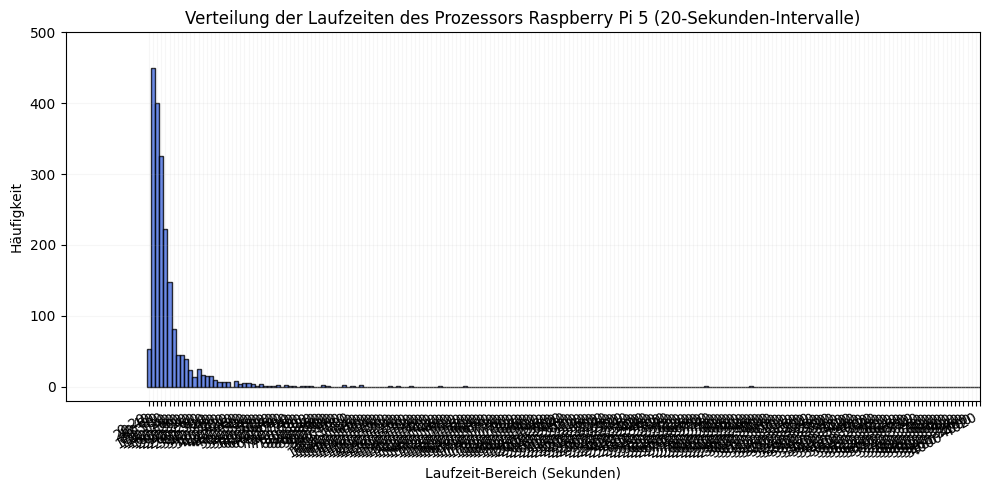

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_Pi5 = data["Raspberry Pi 5"]
runtimes = df_Pi5["runtime_s"]

# 20-Sekunden-Intervalle
bins = np.arange(0, runtimes.max() + 20, 20)

# In Intervalle einteilen
categories = pd.cut(runtimes, bins=bins, right=True)

# Häufigkeit zählen
counts = categories.value_counts().sort_index()

# Labels schöner machen ([a, b])
labels = [f"{int(c.left)}-{int(c.right)}" for c in counts.index]

plt.figure(figsize=(10,5))
plt.bar(labels, counts.values, color="royalblue", edgecolor="black", width=1.0, alpha=0.8)

plt.xlabel("Laufzeit-Bereich (Sekunden)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Laufzeiten des Prozessors Raspberry Pi 5 (20-Sekunden-Intervalle)")
plt.xticks(rotation=30, ha="right")

# Fokus auf Hauptbereich
plt.ylim(-20, 500)
plt.xlim(-20, 200)  # Zoom auf 0–200 Sekunden
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()


In [551]:
import json
import tarfile
from pathlib import Path

def load_dimensions(archive_path):
    """
    Lit toutes les instances JSON d'une archive .tar.gz
    et retourne une liste des dimensions trouvées.
    """
    dimensions = []

    with tarfile.open(archive_path, "r:gz") as tar:
        members = []
        for m in tar.getmembers():
            name = Path(m.name).stem
            parts = name.split('_')
            last = parts[-1]
            # On ne garde que les fichiers se terminant par un nombre (ex: _0.json)
            if last.isdigit():
                members.append(m)

        # Trier les fichiers dans l'ordre numérique (_0, _1, ..., _1999)
        members = sorted(members, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

        # Extraire la dimension de chaque fichier JSON
        for member in members:
            f = tar.extractfile(member)
            if f:
                js = json.load(f)
                if "dimension" in js:
                    dimensions.append(js["dimension"])

    # print(f"{len(dimensions)} dimensions lues depuis {archive_path}")
    return dimensions


In [552]:
import pandas as pd

def combine_dimensions_runtimes(dimensions, runtimes, n,label=None): 
    # Créer un DataFrame
    df = pd.DataFrame({
        'dimension': dimensions[:n],
        'runtime': runtimes[:n],
        'dataset': label
    })

    # print(f"✅ DataFrame créé avec {len(df)} lignes pour {label}")
    return df


In [553]:
# Methode zum Einlesen der Dimensionen aus JSON-Dateien in einem Ordner

def read_dimensions(folder: str, n=2000):
    dims = []
    stem = os.path.basename(folder)
    stems_to_try = [stem, stem + ".1"] if not stem.endswith(".1") else [stem, stem[:-2]]

    for i in range(n):
        candidates = []
        for s in stems_to_try:
            candidates.append(os.path.join(folder, f"{s}_{i}.json"))
            candidates.append(os.path.join(folder, f"{s}_{i}_sol.json"))
        path = next((p for p in candidates if os.path.exists(p)), None)
        if path is None:
            dims.append(None)
            continue
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        dims.append(data.get("dimension"))
    return dims


In [554]:
# Laden der Dimensionen aus den angegebenen Archiven
dims_300_700 = load_dimensions(r"C:\GitProjekts\PDA\b300_700.1.tar.gz")

dims_700_1000 = load_dimensions(r"C:\GitProjekts\PDA\b700_1000.1.tar.gz")

In [555]:
# Laden der Laufzeiten aus den angegebenen Dateien

runs_300_700 = read_and_compute_runtime(r"C:\GitProjekts\PDA\b300_700.1\runtimes.mp80")
runs_700_1000 =read_and_compute_runtime(r"C:\GitProjekts\PDA\b700_1000.1\runtimes.mp80")
#print(runs_300_700["runtime_s"])

# Laufzeiten und Dimensionen kombinieren
df_300_700 = combine_dimensions_runtimes(dims_300_700, runs_300_700["runtime_s"],len(runs_300_700), "b300_700.1")
df_700_1000 = combine_dimensions_runtimes(dims_700_1000, runs_700_1000["runtime_s"],len(runs_700_1000), "b700_1000.1")

# Daten zusammenführen
df_all = pd.concat([df_300_700, df_700_1000], ignore_index=True)

print(df_all)

      dimension  runtime      dataset
0           521     54.0   b300_700.1
1           339     16.0   b300_700.1
2           667    924.0   b300_700.1
3           554     53.0   b300_700.1
4           380     19.0   b300_700.1
...         ...      ...          ...
3995        761    286.0  b700_1000.1
3996        751    387.0  b700_1000.1
3997        708    303.0  b700_1000.1
3998        745    101.0  b700_1000.1
3999        704    331.0  b700_1000.1

[4000 rows x 3 columns]


In [556]:
extreme_row = df_all.loc[df_all["runtime"].idxmax()]
ext_x = extreme_row["dimension"]
ext_y = extreme_row["runtime"]

df_inst = df_all[(df_all["dataset"] == "b700_1000.1") &
                 (df_all["dimension"] == 838)]

print(df_inst)


      dimension  runtime      dataset
2031        838    141.0  b700_1000.1
2637        838    293.0  b700_1000.1
2673        838    534.0  b700_1000.1
2685        838    243.0  b700_1000.1
2849        838    133.0  b700_1000.1
3118        838     78.0  b700_1000.1
3252        838    161.0  b700_1000.1
3415        838     87.0  b700_1000.1
3522        838  31546.0  b700_1000.1


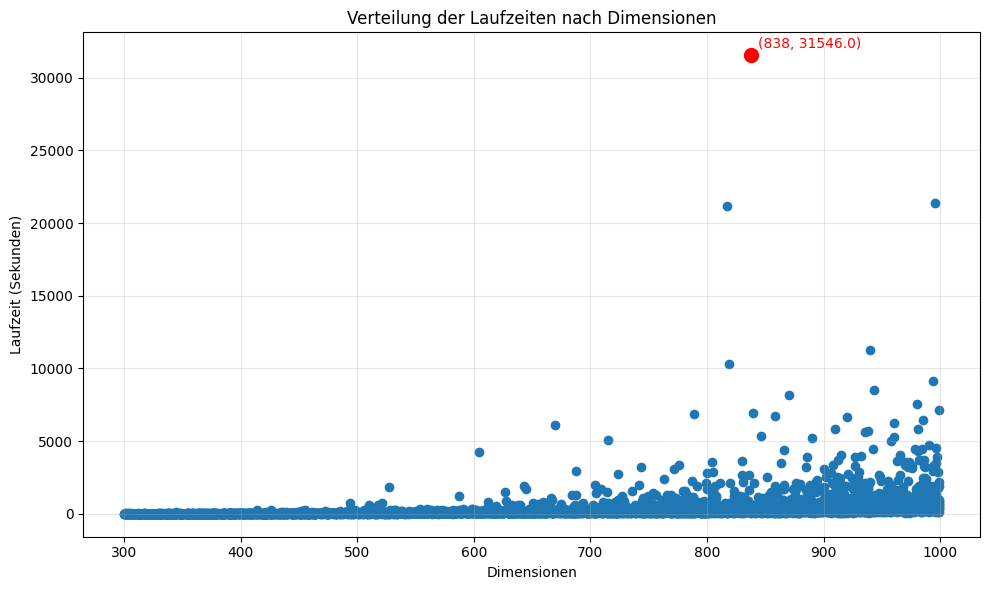

In [557]:
# Visualisierung der Verteilung der Laufzeiten nach Dimensionen

plt.ion()
plt.figure(figsize=(10, 6))
plt.scatter(df_all["dimension"],df_all["runtime"])
plt.scatter(ext_x, ext_y, s=100, color="red", label="Maximum Runtime")
plt.annotate(
    f"({ext_x}, {ext_y})",
    (ext_x, ext_y),
    textcoords="offset points",
    xytext=(5, 5),
    ha='left',
    color="red"
)
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Verteilung der Laufzeiten nach Dimensionen")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

In [558]:
# Extremwerte finden und anzeigen   
extreme_row = df_all.loc[df_all["runtime"].idxmax()]
ext_x = extreme_row["dimension"]
ext_y = extreme_row["runtime"]

df_inst = df_all[(df_all["dataset"] == "b700_1000.1") &
                 (df_all["dimension"] == 838)]
print(df_inst)

      dimension  runtime      dataset
2031        838    141.0  b700_1000.1
2637        838    293.0  b700_1000.1
2673        838    534.0  b700_1000.1
2685        838    243.0  b700_1000.1
2849        838    133.0  b700_1000.1
3118        838     78.0  b700_1000.1
3252        838    161.0  b700_1000.1
3415        838     87.0  b700_1000.1
3522        838  31546.0  b700_1000.1


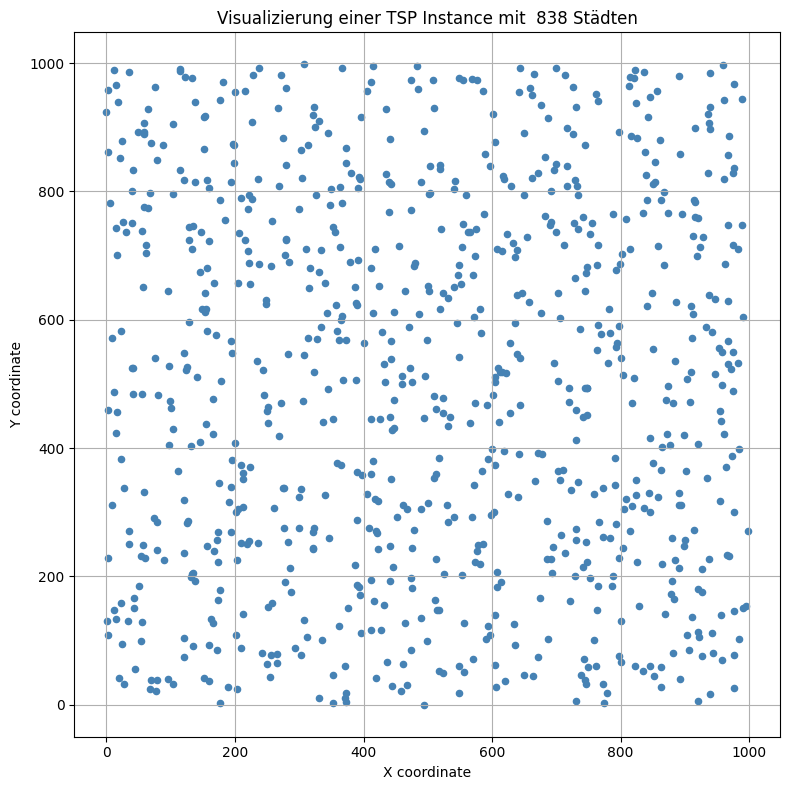

In [559]:
#Visualisierung des Extremwert

# Datei laden
with open(r"C:\GitProjekts\PDA\b700_1000.1\b700_1000.1_1522_sol.json", "r") as f:
    data = json.load(f)

# Koordinaten extrahieren
coords = data["node_coordinates"]

# In zwei Listen aufteilen
x = [c[0] for c in coords]
y = [c[1] for c in coords]

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='steelblue', s=20)
plt.title(f"Visualizierung einer TSP Instance mit  {len(coords)} Städten")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.tight_layout()
plt.savefig("Instanceplot.png")
plt.show()

In [560]:

# 95%-Quantil der Laufzeiten je Dimension berechnen
bins= np.arange(300, 1000, 20)
labels = [f"{b}-{b+19}" for b in bins]

df_all["dim_group"] = pd.cut( df_all["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

quantiles = df_all.groupby("dim_group", observed=True)["runtime"].quantile(0.95).dropna()
 

In [561]:
# Median der Laufzeiten je Dimension berechnen und zum DataFrame hinzufügen
df_all=df_all.sort_values(by="dimension", ascending=True)

df_all["median_dimm"] = (
  df_all.groupby("dim_group", observed=True)["dimension"]
          .transform("median")
)

print( df_all)

      dimension  runtime      dataset dim_group  median_dimm
1624        300     10.0   b300_700.1   300-319        312.0
29          300      7.0   b300_700.1   300-319        312.0
749         301      9.0   b300_700.1   300-319        312.0
603         301     17.0   b300_700.1   300-319        312.0
376         301      8.0   b300_700.1   300-319        312.0
...         ...      ...          ...       ...          ...
3528        999    913.0  b700_1000.1   980-999        992.0
3062        999    403.0  b700_1000.1   980-999        992.0
2344        999    702.0  b700_1000.1   980-999        992.0
3109        999   2181.0  b700_1000.1   980-999        992.0
3183        999    464.0  b700_1000.1   980-999        992.0

[4000 rows x 5 columns]


In [562]:
# Repräsentative Dimensionen pro Gruppe finden

df_representatives = df_all["median_dimm"].unique()
print(df_representatives)


[312.  332.  350.  370.5 391.  411.  429.  452.  472.  492.  511.  530.
 551.  572.  589.  610.  632.  651.  669.5 692.  711.  729.  751.  769.
 790.  809.  830.  851.  871.  891.  911.  930.  952.5 971.  992. ]


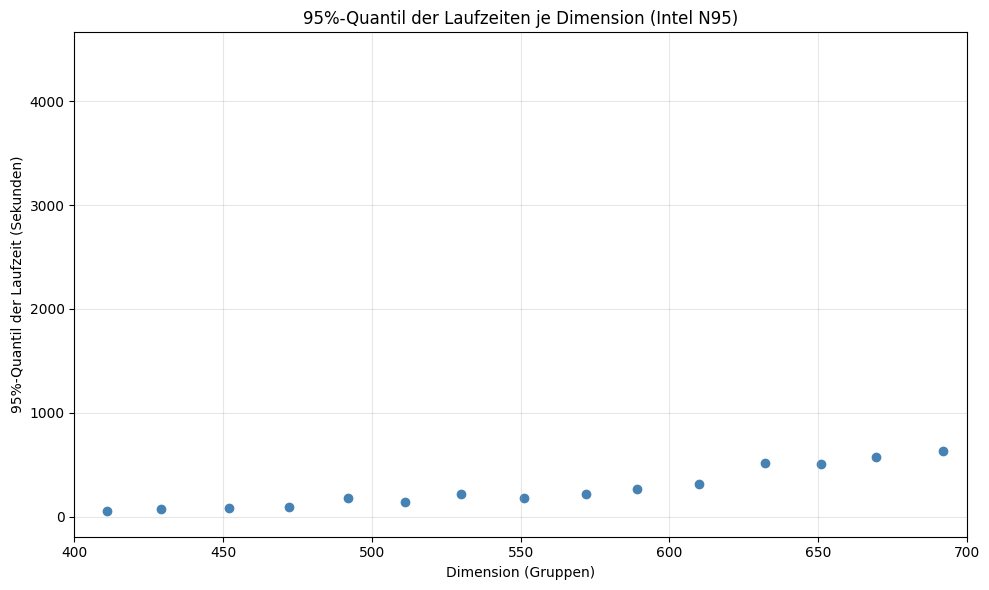

In [563]:
#Repräsentative Dimensionen pro einmal lesen
X2=[x for x in df_representatives]
# Plot 95% quantile vs dimension
plt.figure(figsize=(10, 6))
plt.scatter(X2, quantiles.values, marker="o", linestyle="-", color="steelblue")

plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")
plt.title("95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.xlim(400, 700)
plt.tight_layout()
plt.savefig("quantile_95_plot.2.png")
plt.show()

In [223]:
# Lineare Regression auf den 95%-Quantilen durchführen Zweite Ansatz (hier wird die Dimension, deren Laufzeit gleich  oder am näherste der Median 
# der Entsprechende Bereich liegt,  als Repräsentant der Bereich verwendet)
anzahl_Bereiche=len(quantiles.index)
A=[X2,[1 for _ in range(anzahl_Bereiche)]]
y=np.array([a for a in np.log(quantiles.values)])
A=np.array(A).T
# print(A)
# print(A.shape)
A_T=A.T 
Anew=A_T@A
ynew=A_T@y
print(Anew)
print(ynew)

[[1.62499898e+07 2.27775000e+04]
 [2.27775000e+04 3.50000000e+01]]
[146680.94516501    209.07035047]


In [224]:
result=solve_linear_equation_system(Anew,ynew)
new_lambda1= np.exp(1.128781)
#print(lamda1) x[0] = 0,007444
# x[1] = 1,128781
new_lambda2=0.007444
f_x_2=[new_lambda1*np.exp(new_lambda2*x) for x in X2]
print(result)

[0.007444320974409964, 1.1287808422845023]


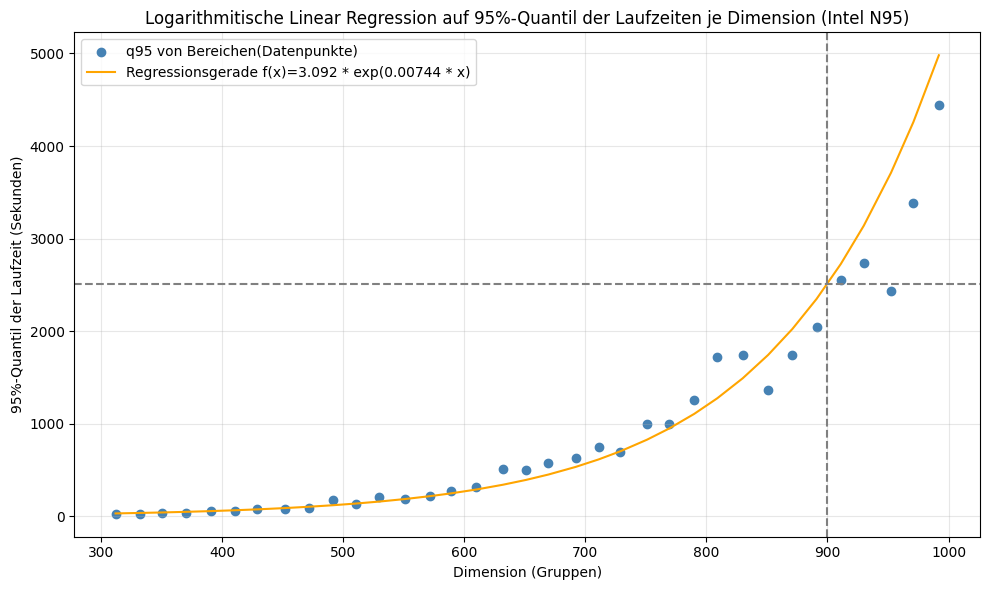

In [26]:
# Plot 95% quantile vs dimension mit Regressionsgerade
plt.figure(figsize=(10, 6))
plt.scatter(X2, quantiles.values, color="steelblue", label="q95 von Bereichen(Datenpunkte)")
plt.plot(X2,f_x_2,linestyle="-", color="orange", label=f"Regressionsgerade f(x)={new_lambda1:.3f} * exp({new_lambda2:.5f} * x)")
plt.axvline(900,linestyle="--", color="gray")
plt.axhline((new_lambda1*np.exp(new_lambda2*900)),linestyle="--", color="gray")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")

plt.title("Logarithmitische Linear Regression auf 95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("LogLinearRegress2.png")
plt.show()

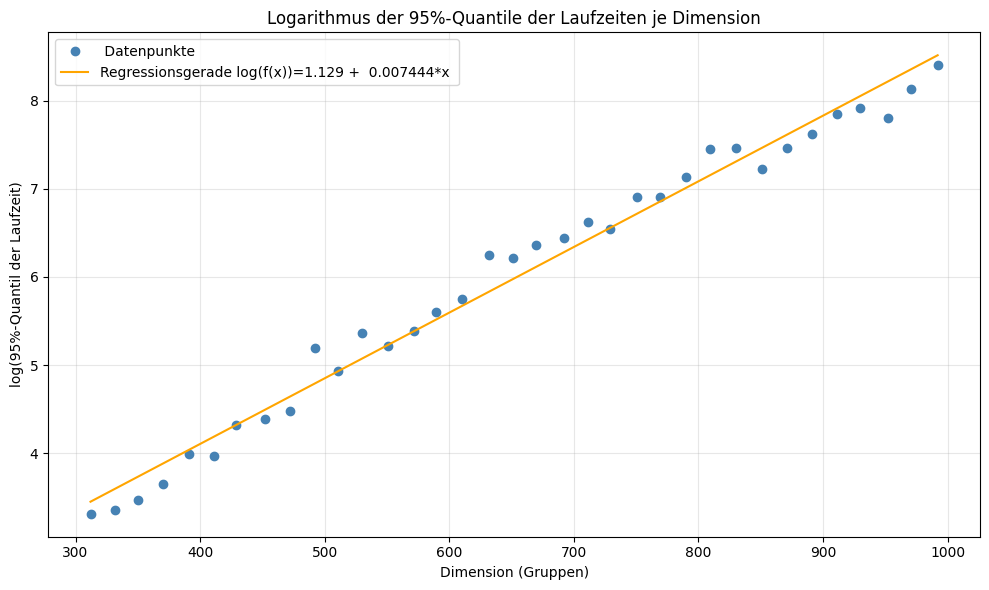

In [27]:
# Plot log(95% quantile) vs dimension mit Regressionsgerade

log_f_x_2=np.log(f_x_2)
plt.figure(figsize=(10, 6))

plt.plot(X2, np.log(quantiles.values),"o", color="steelblue", label=" Datenpunkte")
plt.plot(X2, log_f_x_2,color="Orange", label= f"Regressionsgerade log(f(x))={np.log(new_lambda1):.3f} + {new_lambda2: 5f}*x ")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("log(95%-Quantil der Laufzeit)")
plt.title("Logarithmus der 95%-Quantile der Laufzeiten je Dimension")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Regress_quantile_log_plot_median.png")


plt.show()

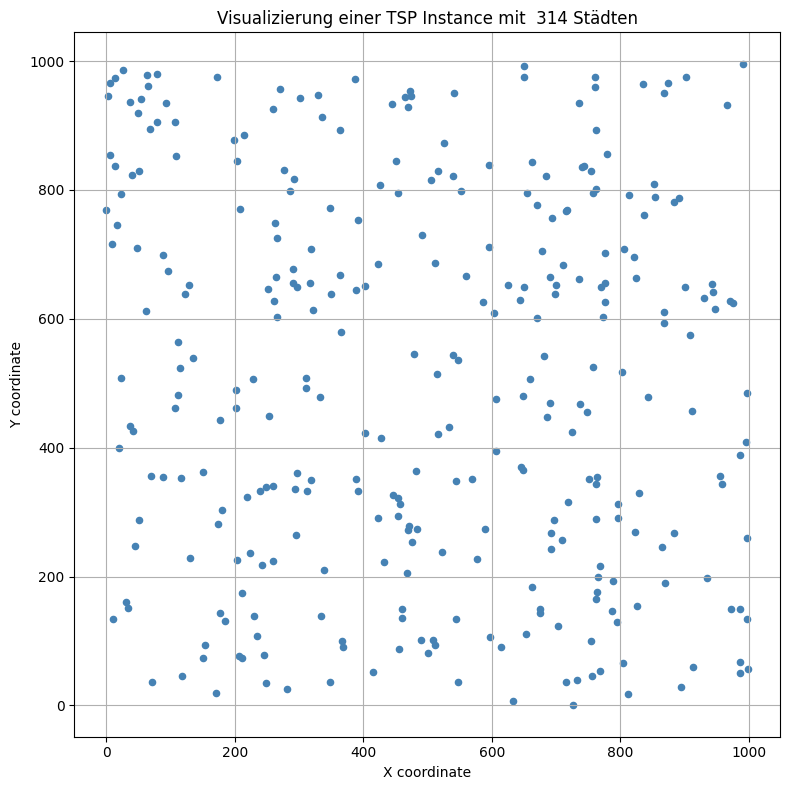

In [71]:
import json
import matplotlib.pyplot as plt

# Datei laden
with open(r"C:\GitProjekts\PDA\b300_700.1\b300_700.1_30_sol.json", "r") as f:
    data = json.load(f)

# Koordinaten extrahieren
coords = data["node_coordinates"]

# In zwei Listen aufteilen
x = [c[0] for c in coords]
y = [c[1] for c in coords]

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='steelblue', s=20)
plt.title(f"Visualizierung einer TSP Instance mit  {len(coords)} Städten")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.tight_layout()
plt.savefig("Instanceplot.png")
plt.show()


In [206]:
# ---------------- Modelbewertung ------------------
# Laden der Dimensionen aus den angegebenen Archiven
dims2_300_700 = load_dimensions(r"C:\GitProjekts\PDA\b300_700.2.tar.gz")

dims2_700_1000 = load_dimensions(r"C:\GitProjekts\PDA\b700_1000.2 (1).tar.gz")

In [207]:
# Laden der Laufzeiten aus den angegebenen Dateien

runs_300_700_2 = read_and_compute_runtime(r"C:\GitProjekts\PDA\b300_700.2\runtimes.mp80")
runs_700_1000_2 =read_and_compute_runtime(r"C:\GitProjekts\PDA\b700_1000.2(1)\runtimes.mp80")
#print(len(runs_700_1000_2))

# Laufzeiten und Dimensionen kombinieren
df_300_700_2 = combine_dimensions_runtimes(dims2_300_700, runs_300_700_2["runtime_s"],len(runs_300_700_2), "b300_700.2")
df_700_1000_2 = combine_dimensions_runtimes(dims2_700_1000, runs_700_1000_2["runtime_s"],len(runs_700_1000_2), "b700_1000.2")

# Daten zusammenführen
df_all_2 = pd.concat([df_300_700, df_700_1000], ignore_index=True)
print(df_all_2)

      dimension  runtime      dataset
0           521     54.0   b300_700.1
1           339     16.0   b300_700.1
2           667    924.0   b300_700.1
3           554     53.0   b300_700.1
4           380     19.0   b300_700.1
...         ...      ...          ...
3995        761    286.0  b700_1000.1
3996        751    387.0  b700_1000.1
3997        708    303.0  b700_1000.1
3998        745    101.0  b700_1000.1
3999        704    331.0  b700_1000.1

[4000 rows x 3 columns]


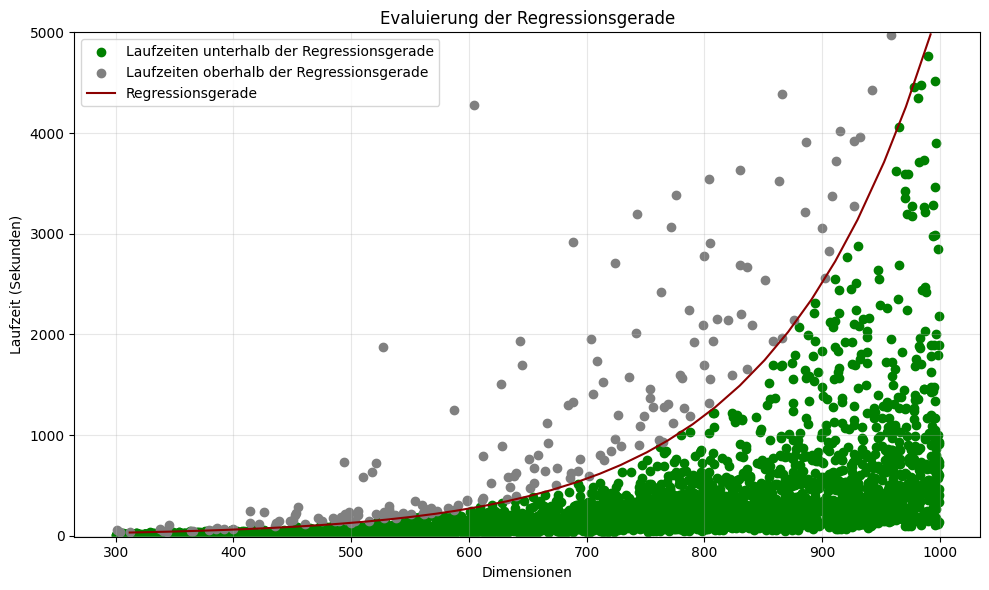

In [61]:

plt.ion()
plt.figure(figsize=(10, 6))
dimensions_x=df_all_2["dimension"].values
laufzeit_y=df_all_2["runtime"].values
Ypred=[new_lambda1*np.exp(new_lambda2*x) for x in dimensions_x]
f_x_=np.array(f_x_)
unter=laufzeit_y<Ypred 
over= laufzeit_y>=Ypred
plt.scatter(dimensions_x[unter],laufzeit_y[unter], color="green", label="Laufzeiten unterhalb der Regressionsgerade")
plt.scatter(dimensions_x[over],laufzeit_y[over], color="gray", label="Laufzeiten oberhalb der Regressionsgerade")
plt.plot(X2,f_x_2,linestyle="-", color="darkred", label="Regressionsgerade")
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Evaluierung der Regressionsgerade")
#plt.xlim(-10, 600)
plt.ylim(-10, 5000)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("testLogLinearRegress.png") 
plt.show()

5.050000000000001
94.95


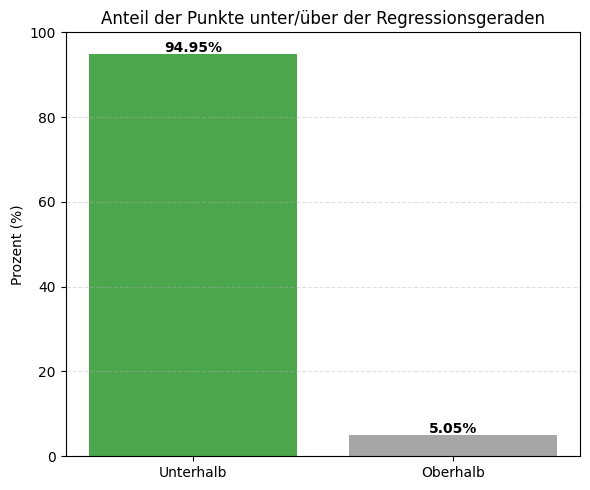

In [62]:
total = len(laufzeit_y)
p_unter = (np.sum(unter) / total) * 100
p_over = (np.sum(over) / total )*100
print(p_over )
print(p_unter)

labelshist = ["Unterhalb", "Oberhalb"]
percentages = [p_unter, p_over]
colors = ["green", "gray"]

plt.figure(figsize=(6, 5))
plt.bar(labelshist, percentages, color=colors, alpha=0.7)
plt.ylabel("Prozent (%)")
plt.title("Anteil der Punkte unter/über der Regressionsgeraden")

# Prozentwerte direkt auf die Balken schreiben
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha="center", fontweight="bold")

plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("testHist.png")
plt.show()


In [2]:
# Erste Schritt zur Bestimmung der Abhängigkeit der Laufzeit von dem Approximationsfaktor

import os
import json
import pandas as pd
import re

def summarize_tsp_folder(folder_path):
    """
    Liest alle _imp und _sol JSON-Dateien im Ordner und erstellt einen DataFrame mit:
    - Instanzname
    - Anzahl der Städte
    - Tourlänge _imp
    - Tourlänge _sol
    - GAP
    Sortiert nach Instanznummer aufsteigend, falls möglich.
    """
    # Zwischenspeicher
    instances = {}

    for filename in os.listdir(folder_path):
        if filename.endswith("_imp.json") or filename.endswith("_sol.json"):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)

            instance_name = filename.replace("b700_1000.2_", "").replace("_imp.json", "").replace("_sol.json", "")
            dimension = data.get("dimension", None)
            tour_length_value = data.get("tourlength", None)

            if instance_name not in instances:
                instances[instance_name] = {"dimension": dimension, "L_imp": None, "L_sol": None}

            if filename.endswith("_imp.json"):
                instances[instance_name]["L_imp"] = tour_length_value
            else:
                instances[instance_name]["L_sol"] = tour_length_value

    # DataFrame erstellen
    rows = []
    for inst, vals in instances.items():
        L_imp = vals["L_imp"]
        L_sol = vals["L_sol"]
        gap = (L_imp - L_sol) / L_sol if L_imp is not None and L_sol is not None and L_sol != 0 else None
        rows.append({
            "instance": inst,
            "dimension": vals["dimension"],
            "L_imp": L_imp,
            "L_sol": L_sol,
            "GAP": gap
        })

    df = pd.DataFrame(rows)

    # Versuch, Instanznummern numerisch zu sortieren
    def extract_number(name):
        match = re.search(r'\d+', name)
        return int(match.group()) if match else float('inf')  # Nicht numerische Namen ans Ende

    df = df.sort_values(by="instance", key=lambda x: x.map(extract_number)).reset_index(drop=True)

    return df

df_summary2 = summarize_tsp_folder(r"C:\GitProjekts\PDA\b700_1000.2(1)")

In [3]:
def read_and_compute_runtime_Prepro(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["id", "start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["pre-end"] = pd.to_datetime(df["pre_end"], format=time_format)
    df["preprocessing_time"]=(df["pre-end"] - df["start"]).dt.total_seconds()
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()
    
    return df

In [4]:

runs_700_1000_2 =read_and_compute_runtime_Prepro(r"C:\GitProjekts\PDA\b700_1000.2(1)\runtimes.mp80")
#print(runs_700_1000_2 )
runs_700_1000_2.loc[runs_700_1000_2["id"] == 260, "runtime_s"] += 3600
#print(runs_700_1000_2.loc[runs_700_1000_2["id"] == 260]) 

df_summary2["Preprocessing"]=runs_700_1000_2["preprocessing_time"]
df_summary2["Total_runtime"]=runs_700_1000_2["runtime_s"]
print(df_summary2)

     instance  dimension  L_imp  L_sol       GAP  Preprocessing  Total_runtime
0           0        900  22008  21899  0.004977           11.0          663.0
1           1        923  22453  22309  0.006455           19.0          273.0
2           2        842  21220  21122  0.004640           12.0           81.0
3           3        848  21462  21349  0.005293           13.0           74.0
4           4        928  22409  22073  0.015222            8.0           96.0
...       ...        ...    ...    ...       ...            ...            ...
1995     1995        724  19652  19483  0.008674           10.0          411.0
1996     1996        722  19687  19471  0.011093            7.0          312.0
1997     1997        990  23219  22885  0.014595           19.0         1166.0
1998     1998        858  21610  21463  0.006849            9.0          639.0
1999     1999        737  20438  20299  0.006848           10.0          315.0

[2000 rows x 7 columns]


In [5]:
bins= np.arange(700, 1000, 10)

labels = [f"{b}-{b+9}" for b in bins]

df_summary2["median_dimm"] = (
  df_summary2.groupby("dimension", observed=True)["dimension"]
          .transform("median")
)   
df_summary2["dim_group"] = pd.cut( df_summary2["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

print(df_summary2 )

     instance  dimension  L_imp  L_sol       GAP  Preprocessing  \
0           0        900  22008  21899  0.004977           11.0   
1           1        923  22453  22309  0.006455           19.0   
2           2        842  21220  21122  0.004640           12.0   
3           3        848  21462  21349  0.005293           13.0   
4           4        928  22409  22073  0.015222            8.0   
...       ...        ...    ...    ...       ...            ...   
1995     1995        724  19652  19483  0.008674           10.0   
1996     1996        722  19687  19471  0.011093            7.0   
1997     1997        990  23219  22885  0.014595           19.0   
1998     1998        858  21610  21463  0.006849            9.0   
1999     1999        737  20438  20299  0.006848           10.0   

      Total_runtime  median_dimm dim_group  
0             663.0        900.0   890-899  
1             273.0        923.0   920-929  
2              81.0        842.0   840-849  
3              

C:\Users\fonte\AppData\Local\Temp\ipykernel_13980\1807143368.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g =df_summary2.groupby('dim_group')
C:\Users\fonte\AppData\Local\Temp\ipykernel_13980\1807143368.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_summary2.groupby('dim_group')['GAP']


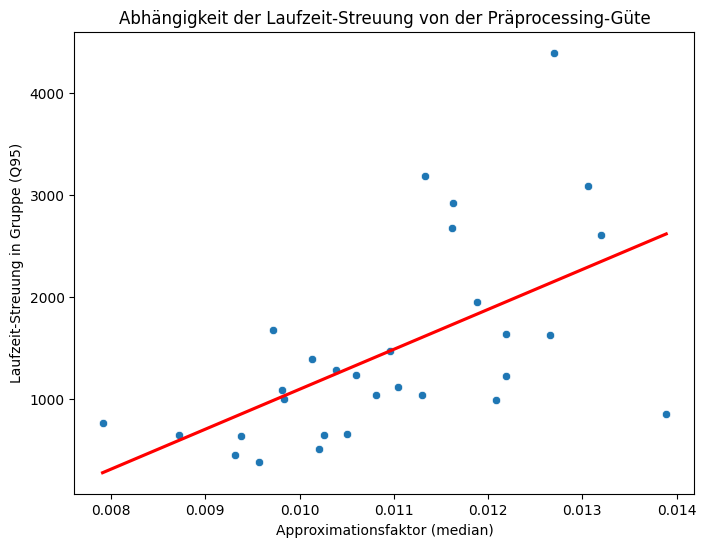

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gruppen bilden und leere Gruppen entfernen
g =df_summary2.groupby('dim_group')
g = {k: v for k, v in g if len(v) > 0}   # nur nicht-leere Gruppen behalten

# 2. Streuung (Q95 - Median) pro Gruppe berechnen   # - np.median(v['Total_runtime'])
spread = {
    k: np.percentile(v['Total_runtime'], 95)
    for k, v in g.items()
}

# Dictionary -> DataFrame umwandeln
spread = (
    pd.DataFrame.from_dict(spread, orient='index', columns=['runtime_spread'])
    .reset_index()
    .rename(columns={'index': 'dim_group'})
)

# 3. Approximationsfaktor pro Gruppe berechnen
approx = (
    df_summary2.groupby('dim_group')['GAP']
    .median()
    .reset_index()
)

# 4. Zusammenführen
merged = spread.merge(approx, on='dim_group', how='inner')


# 5. Plotten
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x='GAP', y='runtime_spread')
sns.regplot(data=merged, x='GAP', y='runtime_spread',ci=None, scatter=False, color='red')

plt.xlabel("Approximationsfaktor (median)")
plt.ylabel("Laufzeit-Streuung in Gruppe (Q95)")
plt.title("Abhängigkeit der Laufzeit-Streuung von der Präprocessing-Güte")
plt.show()


In [10]:
print("Spread groups:", spread['dim_group'].unique())
print("Num spread groups:", len(spread))

print("Approx groups:", approx['dim_group'].unique())
print("Num approx groups:", len(approx))

print("Merged dataframe:")
print(merged)


Spread groups: ['700-709' '710-719' '720-729' '730-739' '740-749' '750-759' '760-769'
 '770-779' '780-789' '790-799' '800-809' '810-819' '820-829' '830-839'
 '840-849' '850-859' '860-869' '870-879' '880-889' '890-899' '900-909'
 '910-919' '920-929' '930-939' '940-949' '950-959' '960-969' '970-979'
 '980-989' '990-999']
Num spread groups: 30
Approx groups: ['700-709', '710-719', '720-729', '730-739', '740-749', ..., '950-959', '960-969', '970-979', '980-989', '990-999']
Length: 30
Categories (30, object): ['700-709' < '710-719' < '720-729' < '730-739' ... '960-969' < '970-979' < '980-989' < '990-999']
Num approx groups: 30
Merged dataframe:
   dim_group  runtime_spread       GAP
0    700-709          451.80  0.009317
1    710-719          505.00  0.010205
2    720-729          643.40  0.008725
3    730-739          758.50  0.007911
4    740-749          378.60  0.009572
5    750-759          640.50  0.009378
6    760-769          646.50  0.010255
7    770-779          653.00  0.010502
8

In [ ]:
# indexes zu bestimmen wie geklustert ein Datensatzt ist. ==>  HOPKINS STATISTIC   wert 0.5 
# HOPKINS STATISTIC (index) 0 < H < 0.5  Datensatzt ist eher gleichmäßig verteilt
# HOPKINS STATISTIC (index) 0.5 < H < 1  Datensatzt ist eher geklustert   wie wird es tatsätlich berechnet?

#Gap--------------- Aproximationsfaktor/ Gütefaktor der Präprocessing-----------------


# Wie hängt die Güte der Präprocessing von Laufzeiten ab? Laufzetrang in Gruppen ( Gruppen von ungefähre gleiche Dimensionen) bilden

# tsp -i b500.1_1.json heuristic greedy  nicht optimal lösen ( gibt outpout aus)  ( Greedy ist ist name des Heuristik Algorithmus)  (kleine o nutzen !!)
# tsp -i b500.1_1.json heuristic greedy | tsp -c -O solve bac  (| ergebniss als imput für nächste Befehl) 
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp -c -O solve bac 
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100 | filer | tsp -c -O solve bac
# tsp -i b500.1_1.json heuristic greedy | tsp improve 2opt | tsp improve locenum -w 200 -s 100 | filer | tsp -c -O xxx.json solve bac (xxx.json ist die datei wo die lösung gespeichert wird)
# tsp -c -o  xxx.json solve bac  (starte direkt mit optimale Lösung)

# ssh [name]@ip-adresse  (um sich mit einem remote rechner zu verbinden) (name ist hier unsere benutzername auf dem remote rechner) 
# scp local-file [name]@ip-adresse:remote-file  (um dateien auf remote rechner zu kopieren)


# SSH Alternativee für Windows  
#mp81-----guroby !§ und debian 3 aber mp80 gurpby 12 und Debian 12  sollte aber keine einfluss haben unf wenn ja nur die Guroby version



#-------------------- Aufgaben für nächste Schritte ----------------------------
# geklusterte Instanzen  300-700  mit einem Gitter größe von 1000*1000 generieren
# Weiterhin Aproximationsfaktor  und Hopkins Index bestimmen


# etwa mit w spielen 

# 2opt ist eine Optimierungsverfahren für das TSP (Travelling Salesman Problem), das darauf abzielt, die Gesamtlänge einer gegebenen Tour zu reduzieren, indem es zwei Kanten der Tour austauscht.
# Der Algorithmus funktioniert nach dem Prinzip, dass durch das Entfernen von zwei Kanten und das Verbinden der entstandenen Segmente auf eine andere Weise eine kürzere Tour entstehen kann.

# Untersuchung wie Schtritt3 zu konfiguriern ist ( also tsp improve locenum -w 200 -s 100) -100 dient für die anzahl der Iterationen  und w für die Fenstergröße ( also wie viele städte werden betrachtet)



df_summary2["median_dimm"] = (
  df_summary2.groupby("dimension", observed=True)["dimension"]
          .transform("median")
)

df_summary2["median_dimm"] = (
  df_summary2.groupby("dimension", observed=True)["dimension"]
          .transform("median")
)


NameError: name 'df_summary2' is not defined

In [447]:

df_representatives_com = df_summary2["median_dimm"].unique()

NameError: name 'df_summary2' is not defined

In [308]:
import random
import math
import json


def generate_points2():
    """Generiert Punkte mit dem gleichen Algorithmus wie in Ihrem Code"""
    points = []
    last_point_in_row = [None for _ in range(GRID_SIZE)]
    last_point_in_col = [None for _ in range(GRID_SIZE)]
    grid = [[0 for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
    
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            # Horizontaler Einfluss
            if last_point_in_row[y] is None:
                horizontal_multiplier = 1.0
            else:
                distance = x - last_point_in_row[y]
                if distance <= 0:
                    distance = 1
                horizontal_multiplier = 10.0 / distance
            
            if x > 0 and grid[y][x-1] == 1:
                horizontal_multiplier = 10.0
            
            # Vertikaler Einfluss
            if last_point_in_col[x] is None:
                vertical_multiplier = 1.0
            else:
                vdist = y - last_point_in_col[x]
                if vdist <= 0:
                    vdist = 1
                vertical_multiplier = 4.0 / vdist
            
            if y > 0 and grid[y-1][x] == 1:
                vertical_multiplier = 4.0
            
            # Diagonaler Einfluss (optional)
            diagonal_multiplier = 1.0
            if x > 0 and y > 0 and grid[y-1][x-1] == 1:
                diagonal_multiplier = 1.50
            
            # Endgültige Wahrscheinlichkeit
            final_prob = BASE_PROB * horizontal_multiplier * vertical_multiplier * diagonal_multiplier
            if final_prob > 1.0:
                final_prob = 1.0
            
            # Punkt erzeugen oder nicht
            if random.random() < final_prob:
                grid[y][x] = 1
                points.append((x, y))
                last_point_in_row[y] = x
                last_point_in_col[x] = y
    
    return points


In [309]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
def hopkins_statistic(X, m=None):
    """
    Compute Hopkins statistic for dataset X (n x d).
    We normalise X to [0,1]^d first, then use
    proper nearest neighbours (excluding self).
    """
    X = np.asarray(X)
    n, d = X.shape

    # normalise to [0,1]^d
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    denom = (maxs - mins)
    denom[denom == 0] = 1.0
    Xn = (X - mins) / denom

    if m is None:
        m = min(100, n // 2)

    # fit NN on normalised data
    nn = NearestNeighbors(n_neighbors=2).fit(Xn)

    # sample m real points
    idx = np.random.choice(n, m, replace=False)
    X_sample = Xn[idx]

    # sample m artificial random points in same space
    U = np.random.rand(m, d)

    # distances from random points to nearest real point
    u_dist, _ = nn.kneighbors(U, n_neighbors=1)
    u = u_dist[:, 0]

    # distances from real points to nearest *other* real point
    w_dist, _ = nn.kneighbors(X_sample, n_neighbors=2)
    w = w_dist[:, 1]   # second neighbour = excluding itself

    H = u.sum() / (u.sum() + w.sum())
    return float(H)




In [394]:
from pathlib import Path

def create_tsp_instance(points, target_dimension):
    """
    Erstellt eine TSP-Instanz aus den generierten Punkten.
    Passt die Anzahl der Punkte an die gewünschte Dimension an.
    """
    # Wenn wir zu viele Punkte haben, wähle eine zufällige Teilmenge
    if len(points) > target_dimension:
        # Zufällige Auswahl, aber versuche, eine gute Verteilung beizubehalten
        selected_indices = random.sample(range(len(points)), target_dimension)
        selected_points = [points[i] for i in selected_indices]
    # Wenn wir zu wenige Punkte haben, füge zusätzliche Punkte hinzu
    elif len(points) < target_dimension:
        selected_points = points.copy()
        # Füge zufällige Punkte hinzu, um die gewünschte Dimension zu erreichen
        while len(selected_points) < target_dimension:
            x = random.randint(0, GRID_SIZE - 1)
            y = random.randint(0, GRID_SIZE - 1)
            selected_points.append((x, y))
    else:
        selected_points = points
    
    return selected_points


   # "comment":"randomly generated problem with 583 cities","dimension":583,"display_data_type":"COORD_DISPLAY","edge_weight_type":"EUC_2D","name":"r583(1229888262)","node_coordinates":

def save_tsp_instance(points, filename,comment, instance_name,path):
    """Speichert die TSP-Instanz im JSON-Format."""

    directory = Path(path)
    directory.mkdir(parents=True, exist_ok=True)
    
    full_path = directory / filename  # kombiniert Pfad + Datei
    
    h=hopkins_statistic(points)
    tsp_data = {
        "comment": comment,
        "hopkins": h,
        "dimension": len(points),
        "display_data_type": "COORD_DISPLAY",
        "edge_weight_type": "EUC_2D",
        "name": instance_name,
        "node_coordinates": points
    }
    
    # JSON in exakt einer Zeile speichern
    with open(full_path, 'w') as f:
        json.dump(tsp_data, f )
    



In [395]:
def visualize_points(points, filename="generated_points.png"):
    """Visualisiert Punkte mit Y von unten nach oben"""
    import matplotlib.pyplot as plt
    
    if not points:
        print("Keine Punkte zum Visualisieren")
        return
    
    px = [p[0] for p in points]
    py = [p[1] for p in points]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(px, py, s=10,c='steelblue')
    
    # KEINE Y-Achsen-Invertierung mehr
    # plt.gca().invert_yaxis()  # AUSKOMMENTIERT
    
    plt.gca().set_aspect("equal", "box")
    plt.title(f"{INSTANCE_NAME} - {len(points)} cities ")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True, alpha=0.3)
    
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.show()
    
    return filename


Grid size: 1000×1000
Spawned points: 562


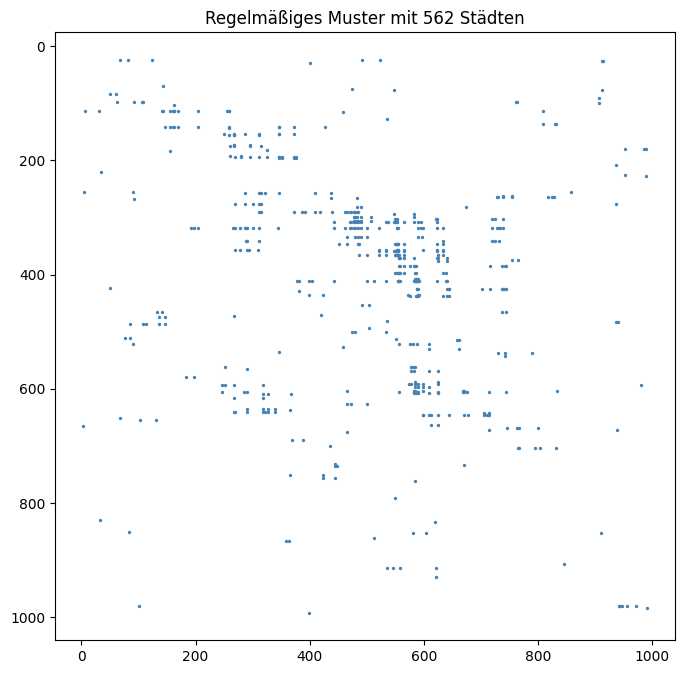

In [415]:


import random
import math
import matplotlib.pyplot as plt
# Parameter für die Instanz

COMMENT = "Generated pattern instance"
GRID_SIZE = 1000  # Größe des Koordinatengitters

BASE_DENSITY = 0.0001    #0,01%  # expected density (scale-invariant)

HORIZONTAL_STRENGTH = 200.0
VERTICAL_STRENGTH = 50.0

DECAY_SCALE = 0.03        # relative distance (3% of grid)


def new_generate_points():
    # INIT
    points = []
    last_point_in_row = [None] * GRID_SIZE
    last_point_in_col = [None] * GRID_SIZE
    grid = [[0] * GRID_SIZE for _ in range(GRID_SIZE)]

    # MAIN LOOP
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            
            # Horizontal influence
            if last_point_in_row[y] is None:
                horizontal_multiplier = 1.0
            else:
                dist = abs(x - last_point_in_row[y]) / GRID_SIZE
                horizontal_multiplier = 1.0 + HORIZONTAL_STRENGTH * math.exp(-dist / DECAY_SCALE)

            # Strong immediate neighbor
            if x > 0 and grid[y][x-1] == 1:
                horizontal_multiplier *= 2.0

            # Vertical influence
            if last_point_in_col[x] is None:
                vertical_multiplier = 1.0
            else:
                vdist = abs(y - last_point_in_col[x]) / GRID_SIZE
                vertical_multiplier = 1.0 + VERTICAL_STRENGTH * math.exp(-vdist / DECAY_SCALE)

            if y > 0 and grid[y-1][x] == 1:
                vertical_multiplier *= 1.8

            # Final probability
            final_prob = BASE_DENSITY * horizontal_multiplier * vertical_multiplier
            final_prob = min(final_prob, 0.9)   # safety cap

            if random.random() < final_prob:
                grid[y][x] = 1
                points.append((x, y))
                last_point_in_row[y] = x
                last_point_in_col[x] = y
    
    return points

# OUTPUT
points=new_generate_points()
print(f"Grid size: {GRID_SIZE}×{GRID_SIZE}")
print(f"Spawned points: {len(points)}")
px = [p[0] for p in points]
py = [p[1] for p in points]
plt.figure(figsize=(8, 8))
plt.scatter(px, py, s=2 ,c='steelblue')
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal", "box")
plt.title(f"Regelmäßiges Muster mit {len(points)} Städten")

#plt.savefig("grid_pattern_scaled.png", dpi=200)
plt.show()

In [451]:

DIMENSION = 500  # Ziel-Dimension der TSP-Instanz
def main():
    INSTANCE_NAME = "regelmaessig_instanz"
    # Punkte generieren
    print("\nGenerating points...")
    treat=0
    for i in range(30000):
    
        all_points =new_generate_points()
        print(f"Generated {len(all_points)} points initially")
        final_points =[]
        # An Ziel-Dimension anpassen
        #print(f"Adjusting to target dimension {DIMENSION}...")
       
        if (len(all_points) < DIMENSION and len(all_points)>449):
            final_points = create_tsp_instance(all_points, DIMENSION) 
            # Instanz speichern
            json_file = "treated_" + str(treat) + "_.json"
            path= r"C:\GitProjekts\PDA\treated_regelmaessig"
            
            save_tsp_instance( final_points , json_file, COMMENT, INSTANCE_NAME, path)
            treat+=1
        
            # all_points  #
        
        print(f"Final number of points: {len(final_points)}")

        # Instanz speichern
        #json_file = "regelmaessig500_" + str(i) + "_.json"
        #path= r"C:\GitProjekts\PDA\R500_regelmaessig"
        
        # Visualisierung (Y von unten nach oben)
        print("\nCreating visualization ...")
        vis_file = visualize_points( final_points , f"{INSTANCE_NAME}_2.png")
        print(f"Saved visualization: {vis_file}") 
    
        #save_tsp_instance( final_points , json_file, COMMENT, INSTANCE_NAME, path)
        
        
   
    
"""# Visualisierung (Y von unten nach oben)
    print("\nCreating visualization (Y from bottom to top)...")
    vis_file = visualize_points( final_points , f"{INSTANCE_NAME}_2.png")
    print(f"Saved visualization: {vis_file}") """
    

if __name__ == "__main__":
    # Setze Random Seed für Reproduzierbarkeit
    # random.seed(42)
    #main()
    print("DONE !")

DONE !


In [452]:
from pathlib import Path
import json

def load_dimension_simple_directory(directory_path):
    """
    Durchsucht ein normales Verzeichnis und liest die Dimension
    aus allen enthaltenen JSON-Dateien.
    """
    dimensions = []
    directory = Path(directory_path)

    # Alle JSON-Dateien im Ordner finden
    json_files = list(directory.glob("*.json"))

    # Optional: sortieren, falls Dateien z.B. instance_0.json, instance_1.json ... heißen
    json_files.sort(key=lambda x: int(x.stem.split('_')[-1]) if x.stem.split('_')[-1].isdigit() else float('inf'))

    # Daten auslesen
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if "dimension" in data:
                    dimensions.append(data["dimension"])
        except Exception as e:
            print(f"Fehler beim Lesen von {file.name}: {e}")

    return dimensions

In [453]:
regelmaessig1= load_dimension_simple_directory(r"C:\GitProjekts\PDA\Regelmaessige_Instanzen_Mit_Hopkins") 
regelmaessig1=pd.DataFrame(regelmaessig1, columns=["dimension"])
regelmaessig2= load_dimension_simple_directory(r"C:\GitProjekts\PDA\regelmaessig_mit_hopkins")
regelmaessig2=pd.DataFrame(regelmaessig2, columns=["dimension"])
regelmaessig3= load_dimension_simple_directory(r"C:\GitProjekts\PDA\regelmaessig_hi")
regelmaessig3=pd.DataFrame(regelmaessig3, columns=["dimension"])



KeyboardInterrupt: 

In [ ]:
print(regelmaessig1)
print(regelmaessig2)
print(regelmaessig3)
   

      dimension
0           611
1           201
2           233
3           475
4           874
...         ...
2995        383
2996        544
2997        574
2998        231
2999        304

[3000 rows x 1 columns]
      dimension
0           565
1           426
2           381
3           332
4           271
...         ...
2995        291
2996       4387
2997        313
2998        486
2999        360

[3000 rows x 1 columns]
      dimension
0           494
1           370
2           412
3           213
4           421
...         ...
2995        326
2996        443
2997        304
2998        339
2999        326

[3000 rows x 1 columns]


In [ ]:
regelmaessig4= load_dimension_simple_directory(r"C:\GitProjekts\PDA\R500_regelmaessig")
regelmaessig4=pd.DataFrame(regelmaessig4, columns=["dimension"])
print(regelmaessig4) 

      dimension
0           500
1           500
2           500
3           500
4           500
...         ...
2495        500
2496        500
2497        500
2498        500
2499        500

[2500 rows x 1 columns]


In [515]:
df1 =regelmaessig1.loc[(regelmaessig1["dimension"] >= 400) & (regelmaessig1["dimension"] <= 700)][["dimension"]]
df1 = df1.reset_index()

df2=regelmaessig2.loc[(regelmaessig2["dimension"] >= 400) & (regelmaessig2["dimension"] <= 700  )][["dimension"]]
df2 = df2.reset_index()

df3=regelmaessig3.loc[(regelmaessig3["dimension"] >= 400) & (regelmaessig3["dimension"] <= 700  )][["dimension"]]
df3 = df3.reset_index()

print(df1)
print(df2)  
print(df3)

     index  dimension
0        0        611
1        3        475
2        5        449
3        7        417
4        9        414
..     ...        ...
888   2988        604
889   2990        554
890   2991        539
891   2996        544
892   2997        574

[893 rows x 2 columns]
     index  dimension
0        0        565
1        1        426
2        6        448
3        9        447
4       10        457
..     ...        ...
903   2979        487
904   2983        435
905   2987        479
906   2988        534
907   2998        486

[908 rows x 2 columns]
     index  dimension
0        0        494
1        2        412
2        4        421
3        9        444
4       12        441
..     ...        ...
872   2980        517
873   2988        548
874   2990        422
875   2991        420
876   2996        443

[877 rows x 2 columns]


In [ ]:
import shutil
from pathlib import Path

def copy_selected_json(df, source_dir, target_dir,pattern):
    source = Path(source_dir)
    target = Path(target_dir)

    # Zielordner erstellen, falls er nicht existiert
    target.mkdir(parents=True, exist_ok=True)

    for idx in df["index"]:
        # Datei suchen: Muster Regelmaessig_{index}_.json
        patternf = pattern + str(idx)+"_.json"  
        file_path = source / patternf

        if file_path.exists():
            shutil.copy(file_path, target / file_path.name)
        else:
            print(f"⚠ Datei nicht gefunden: {pattern}")

    print("✅ Kopiervorgang abgeschlossen!")


In [ ]:
pattern1 = "regelmaessig_" 
copy_selected_json(
    df1,
    r"C:\GitProjekts\PDA\Regelmaessige_Instanzen_Mit_Hopkins",
    r"C:\GitProjekts\PDA\final_regelmaessig_hi",
    pattern1
)   
pattern2 = "regelmaessig_1_" 
copy_selected_json(
    df2,
    r"C:\GitProjekts\PDA\regelmaessig_mit_hopkins",
    r"C:\GitProjekts\PDA\final_regelmaessig_hi",
    pattern2
)

KeyboardInterrupt: 

In [ ]:
pattern3 = f"regelmaessig_2_"  #3
copy_selected_json(
    df3,
    r"C:\GitProjekts\PDA\regelmaessig_hi",
    r"C:\GitProjekts\PDA\final_regelmaessig_hi",
    pattern3
)

✅ Kopiervorgang abgeschlossen!


In [ ]:
import shutil
from pathlib import Path

def copy_and_rename_json(df, source_dir, target_dir,pattern, copied = 0,):
    source = Path(source_dir)
    target = Path(target_dir)
    target.mkdir(parents=True, exist_ok=True)


    for _, row in df.iterrows():
        idx = row["index"]
        patern_new= pattern + str(idx)+"_.json"

        # Originaldatei (z. B. Regelmaessig_0_.json)
        original = source / patern_new

        if original.exists():
        
            new_name = f"R400_700_{ copied}.json"

            shutil.copy(original, target / new_name)
            copied += 1
        else:
            print(f"⚠ Nicht gefunden: {original.name}")

    print(f"✅ Fertig! {copied} Dateien kopiert und umbenannt.")


In [ ]:
copy_and_rename_json(
    df3,
    r"C:\GitProjekts\PDA\regelmaessig_hi",
    r"C:\GitProjekts\PDA\regelmaessig_hi_final",
    pattern3
)

✅ Fertig! 877 Dateien kopiert und umbenannt.


In [ ]:
pattern1 = "regelmaessig_" 
copy_and_rename_json(
    df1,
    r"C:\GitProjekts\PDA\Regelmaessige_Instanzen_Mit_Hopkins",
    r"C:\GitProjekts\PDA\regelmaessig_hi_final",
    pattern1, copied=877
)   


✅ Fertig! 1770 Dateien kopiert und umbenannt.


In [ ]:
pattern2 = "regelmaessig_1_" 
copy_and_rename_json(
    df2,
    r"C:\GitProjekts\PDA\regelmaessig_mit_hopkins",
    r"C:\GitProjekts\PDA\regelmaessig_hi_final",
    pattern2,1770)

✅ Fertig! 2678 Dateien kopiert und umbenannt.


In [497]:
R400_700= read_and_compute_runtime("R400_700_runtimes.mp80")
print(R400_700) 

        id               start              pre_end          solver_end  \
0        0 2026-01-08 09:58:34  08.01.2026-09:58:43 2026-01-08 09:58:58   
1        1 2026-01-08 09:58:58  08.01.2026-09:58:58 2026-01-08 09:58:58   
2        2 2026-01-08 09:58:58  08.01.2026-09:59:10 2026-01-08 09:59:15   
3        3 2026-01-08 09:59:15  08.01.2026-09:59:27 2026-01-08 09:59:37   
4        4 2026-01-08 09:59:37  08.01.2026-09:59:50 2026-01-08 10:01:17   
...    ...                 ...                  ...                 ...   
2538  2538 2026-01-14 07:05:34  14.01.2026-07:05:55 2026-01-14 07:06:40   
2539  2539 2026-01-14 07:06:40  14.01.2026-07:07:06 2026-01-14 07:08:25   
2540  2540 2026-01-14 07:08:25  14.01.2026-07:08:34 2026-01-14 07:08:37   
2541  2541 2026-01-14 07:08:37  14.01.2026-07:08:44 2026-01-14 07:09:13   
2542  2542 2026-01-14 07:09:13  14.01.2026-07:09:24 2026-01-14 07:09:47   

      runtime_s  
0          24.0  
1           0.0  
2          17.0  
3          22.0  
4        

In [498]:
results=[]

mean = R400_700["runtime_s"].mean()
median = R400_700["runtime_s"].median()
var = R400_700["runtime_s"].var()
std = R400_700["runtime_s"].std()
max=R400_700["runtime_s"].max()
min=R400_700["runtime_s"].min()
name="R400_700" 
results.append({'Name': name,'Mean': mean,'Median': median,'Varianz': var, 'Standardabweichung': std, 'MinZeit (in Sekunden)': min,'MaxZeit(in Sekunden': max})

# jetz als DataFrame umwandeln
R400_700_mmvs_df = pd.DataFrame(results)

print(R400_700_mmvs_df) 

       Name        Mean  Median       Varianz  Standardabweichung  \
0  R400_700  199.870625    28.0  8.457179e+06         2908.122944   

   MinZeit (in Sekunden)  MaxZeit(in Sekunden  
0                    0.0             133911.0  


In [505]:
def load_dimensions2(archive_path):
    dimensions = []

    with tarfile.open(archive_path, "r:gz") as tar:
        members = []
        for m in tar.getmembers():
            name = Path(m.name).stem
            last = name.split('_')[-1]
            if last.isdigit():
                members.append(m)

        members.sort(key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

        for member in members:
            f = tar.extractfile(member)
            if not f:
                continue

            try:
                text = f.read().decode("utf-8").strip()
                js = json.loads(text)
                if "dimension" in js:
                    dimensions.append(js["dimension"])
            except json.JSONDecodeError:
                print("JSON invalide :", member.name)
            except UnicodeDecodeError:
                print("Encodage invalide :", member.name)

    return dimensions


In [506]:
dims_400_700 = load_dimensions2(r"C:\GitProjekts\PDA\R400_700.tar.gz")


JSON invalide : R400_700/runtimes_R400_700.mp80


In [ ]:
df_R400_700 = combine_dimensions_runtimes(dims_400_700, R400_700["runtime_s"],len(R400_700), "R400_700")
print(df_R400_700)

#print(df_R400_700["dimension"].max())


 df_R400_700_2=df_R400_700.loc[(df_R400_700["dimension"] >= 400) & (df_R400_700["dimension"] <= 700)][["dimension"]]
   


      dimension  runtime   dataset
0           494     24.0  R400_700
1         50413      0.0  R400_700
2           320     17.0  R400_700
3           326     22.0  R400_700
4           355    100.0  R400_700
...         ...      ...       ...
2538        440     66.0  R400_700
2539        629    105.0  R400_700
2540        226     12.0  R400_700
2541        395     36.0  R400_700
2542        407     34.0  R400_700

[2543 rows x 3 columns]
      dimension
0           494
8           430
9           529
15          481
19          459
...         ...
2536        410
2537        418
2538        440
2539        629
2542        407

[761 rows x 1 columns]


In [511]:
extreme_row = df_R400_700.loc[df_R400_700["runtime"].idxmax()]
ext_x_ = extreme_row["dimension"]
ext_y_ = extreme_row["runtime"]
""""
df_inst = df_R400_700[(df_R400_700["dataset"] == "b700_1000.1") &
                 (df_R400_700["dimension"] == 838)]

print(df_inst)"""

'"\ndf_inst = df_R400_700[(df_R400_700["dataset"] == "b700_1000.1") &\n                 (df_R400_700["dimension"] == 838)]\n\nprint(df_inst)'

In [521]:
df_R400_700_2 = df_R400_700[
    df_R400_700["dimension"].between(400, 700)
].copy()

print(df_R400_700_2) 


      dimension  runtime   dataset
0           494     24.0  R400_700
8           430     16.0  R400_700
9           529    105.0  R400_700
15          481     60.0  R400_700
19          459     51.0  R400_700
...         ...      ...       ...
2536        410     21.0  R400_700
2537        418     34.0  R400_700
2538        440     66.0  R400_700
2539        629    105.0  R400_700
2542        407     34.0  R400_700

[761 rows x 3 columns]


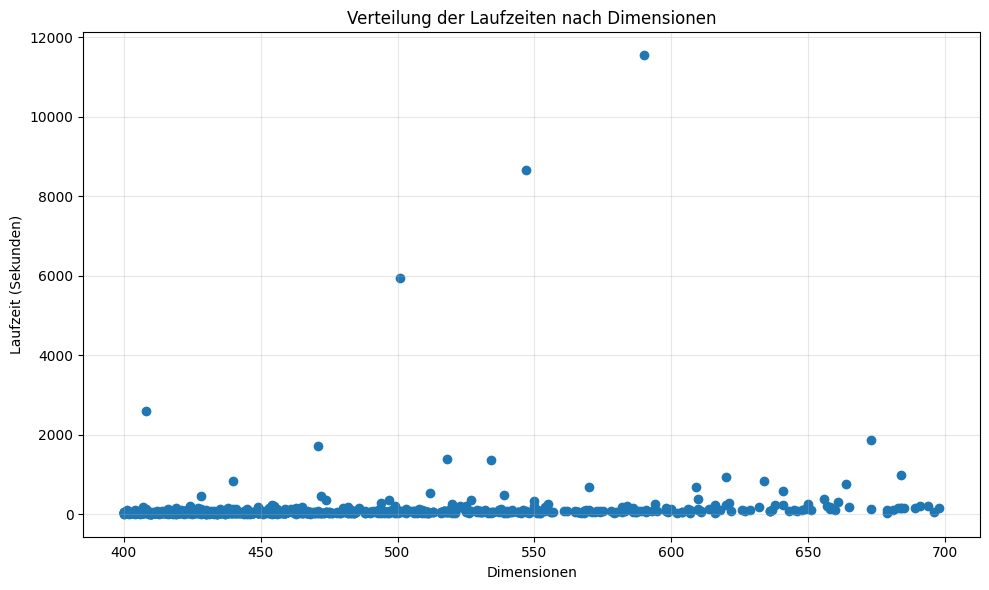

In [522]:
# Visualisierung der Verteilung der Laufzeiten nach Dimensionen

plt.ion()
plt.figure(figsize=(10, 6))
plt.scatter(df_R400_700_2["dimension"],df_R400_700_2["runtime"])
plt.xlabel("Dimensionen")
plt.ylabel("Laufzeit (Sekunden)")
plt.title("Verteilung der Laufzeiten nach Dimensionen")
#plt.xlim(-10, 600)
#plt.ylim(-10, 80)
plt.tight_layout()
plt.savefig("runtime_distribution111.png") 
plt.grid(True, alpha=0.3)
plt.show()

In [544]:
# 95%-Quantil der Laufzeiten je Dimension berechnen
bins= np.arange(300, 700, 20)
labels = [f"{b}-{b+19}" for b in bins]

df_R400_700_2["dim_group"] = pd.cut( df_R400_700_2["dimension"],bins=np.append(bins, 1000),labels=labels,include_lowest=True)

quantiles400_700 = df_R400_700_2.groupby("dim_group", observed=True)["runtime"].quantile(0.95).dropna()

In [545]:
# Median der Laufzeiten je Dimension berechnen und zum DataFrame hinzufügen
df_R400_700_2= df_R400_700_2.sort_values(by="dimension", ascending=True)

df_R400_700_2["median_dimm"] = (
  df_R400_700_2.groupby("dim_group", observed=True)["dimension"]
          .transform("median")
)

print( df_R400_700_2)

      dimension  runtime   dataset dim_group  median_dimm
1000        400     29.0  R400_700   380-399        400.0
2043        400     18.0  R400_700   380-399        400.0
1041        400     38.0  R400_700   380-399        400.0
2119        400     24.0  R400_700   380-399        400.0
839         400     58.0  R400_700   380-399        400.0
...         ...      ...       ...       ...          ...
2147        689    163.0  R400_700   680-699        685.0
1078        691    202.0  R400_700   680-699        685.0
21          694    214.0  R400_700   680-699        685.0
2446        696     71.0  R400_700   680-699        685.0
628         698    148.0  R400_700   680-699        685.0

[761 rows x 5 columns]


In [546]:

df_representatives_R400_700 = df_R400_700_2["median_dimm"].unique()
print(df_representatives_R400_700)


[400.  411.  429.  449.  469.  489.  511.  532.  550.  569.5 588.5 610.
 633.  650.  673.  685. ]


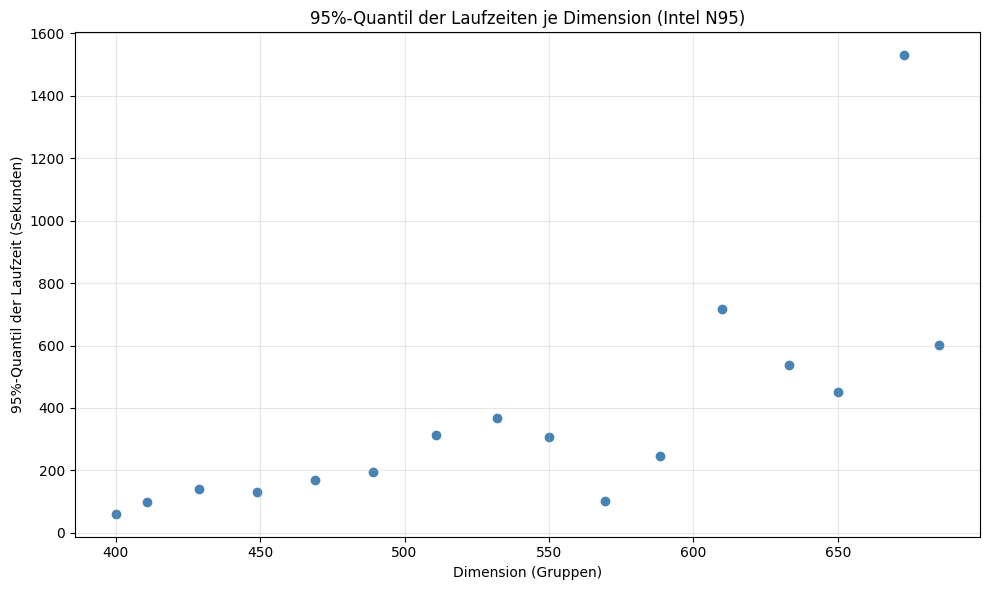

In [547]:
#Repräsentative Dimensionen pro einmal lesen
X400_700=[x for x in df_representatives_R400_700]
# Plot 95% quantile vs dimension
plt.figure(figsize=(10, 6))
plt.scatter(X400_700, quantiles400_700.values, marker="o", linestyle="-", color="steelblue")

plt.xlabel("Dimension (Gruppen)")
plt.ylabel("95%-Quantil der Laufzeit (Sekunden)")
plt.title("95%-Quantil der Laufzeiten je Dimension (Intel N95)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig("quantile_95_plot.2.png")
plt.show()

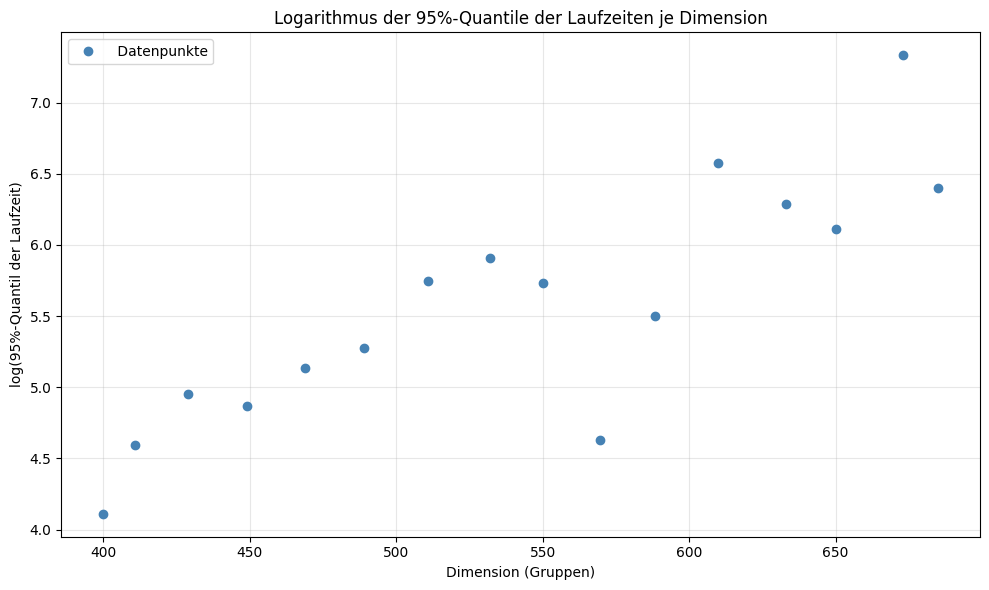

In [548]:
# Plot log(95% quantile) vs dimension mit Regressionsgerade

#log_f_x_2=np.log(f_x_2)
plt.figure(figsize=(10, 6))

plt.plot(X400_700, np.log(quantiles400_700.values),"o", color="steelblue", label=" Datenpunkte")
#plt.plot(X2, log_f_x_2,color="Orange", label= f"Regressionsgerade log(f(x))={np.log(new_lambda1):.3f} + {new_lambda2: 5f}*x ")
plt.xlabel("Dimension (Gruppen)")
plt.ylabel("log(95%-Quantil der Laufzeit)")
plt.title("Logarithmus der 95%-Quantile der Laufzeiten je Dimension")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig("Regress_quantile_log_plot_median.png")


plt.show()

In [524]:
# Aufgabe Boxplot u400_1000.1

# was pasiiert mit dem q95, schwären Instanzen?

In [481]:
import pandas as pd
def read_and_compute_runtime_extended(filename):
    df = pd.read_csv(filename, sep=r"\s+", header=None,
                     names=["Groesse","Cat-id", "Windows","shift","start", "pre_end", "solver_end"])

    time_format = "%d.%m.%Y-%H:%M:%S"
    df["start"] = pd.to_datetime(df["start"], format=time_format)
    df["solver_end"] = pd.to_datetime(df["solver_end"], format=time_format)
    df["runtime_s"] = (df["solver_end"] - df["start"]).dt.total_seconds()

    return df


In [483]:
U400_1000=read_and_compute_runtime_extended("U400_1000_runtimes.i9")

In [484]:
print(U400_1000)

      Groesse  Cat-id  Windows  shift               start  \
0         400       0      100     50 2025-12-22 21:18:48   
1         400       1      100     50 2025-12-22 21:19:04   
2         400       2      100     50 2025-12-22 21:19:19   
3         400       3      100     50 2025-12-22 21:19:48   
4         400       4      100     50 2025-12-22 21:20:17   
...       ...     ...      ...    ...                 ...   
5095     1000      95      650    325 2026-01-08 08:19:07   
5096     1000      96      650    325 2026-01-08 08:24:30   
5097     1000      97      650    325 2026-01-08 08:32:30   
5098     1000      98      650    325 2026-01-08 08:51:09   
5099     1000      99      650    325 2026-01-08 09:06:01   

                  pre_end          solver_end  runtime_s  
0     22.12.2025-21:18:50 2025-12-22 21:19:04       16.0  
1     22.12.2025-21:19:06 2025-12-22 21:19:19       15.0  
2     22.12.2025-21:19:21 2025-12-22 21:19:48       29.0  
3     22.12.2025-21:19:50 2025-

In [488]:
mean_runtime = (
    U400_1000.groupby(["Groesse", "Windows"])
      ["runtime_s"]
      .mean()
      .reset_index()
)

print(mean_runtime) 

    Groesse  Windows  runtime_s
0       400      100      19.95
1       400      150      17.94
2       400      200      18.16
3       400      250      21.96
4       400      300      25.56
5       500      100      36.31
6       500      150      35.24
7       500      200      31.57
8       500      250      34.70
9       500      300      37.15
10      500      350      49.85
11      600      150      73.88
12      600      200      65.08
13      600      250      66.55
14      600      300      71.59
15      600      350      76.91
16      600      400      86.17
17      700      150     161.47
18      700      200     139.82
19      700      250     140.99
20      700      300     134.31
21      700      350     139.53
22      700      400     169.07
23      700      450     188.88
24      800      200     182.67
25      800      250     177.28
26      800      300     164.52
27      800      350     163.17
28      800      400     191.55
29      800      450     187.73
30      

<Axes: title={'center': 'runtime_s'}, xlabel='Windows'>

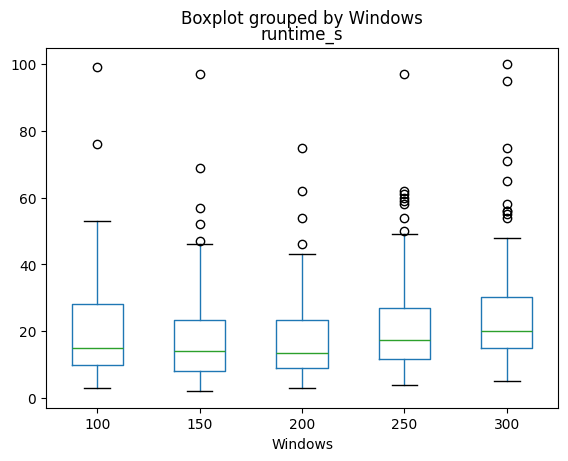

In [491]:
df_400 = U400_1000[U400_1000["Groesse"] == 400]

df_400.boxplot(
    column="runtime_s",
    by="Windows",
    grid=False
)


In [493]:
quantile_95 = (
    U400_1000.groupby(["Groesse", "Windows"])
      ["runtime_s"]
      .quantile(0.95)
      .reset_index(name="q95_runtime")
)

print(quantile_95)

    Groesse  Windows  q95_runtime
0       400      100        42.15
1       400      150        46.05
2       400      200        41.10
3       400      250        58.05
4       400      300        58.35
5       500      100        66.50
6       500      150        65.10
7       500      200        61.10
8       500      250        64.10
9       500      300        69.30
10      500      350        92.10
11      600      150       147.70
12      600      200       150.50
13      600      250       177.00
14      600      300       153.20
15      600      350       160.95
16      600      400       163.20
17      700      150       379.00
18      700      200       328.25
19      700      250       264.20
20      700      300       324.30
21      700      350       378.30
22      700      400       277.40
23      700      450       358.25
24      800      200       377.00
25      800      250       447.50
26      800      300       366.60
27      800      350       300.85
28      800   

In [496]:
summary = (
    U400_1000.groupby(["Groesse", "Windows"])
      ["runtime_s"]
      .agg(["mean", "median", "std"])
      .reset_index()
)

print(summary)  

    Groesse  Windows     mean  median          std
0       400      100    19.95    15.0    14.952028
1       400      150    17.94    14.0    14.636208
2       400      200    18.16    13.5    12.979175
3       400      250    21.96    17.5    15.726783
4       400      300    25.56    20.0    17.653981
5       500      100    36.31    34.5    25.761413
6       500      150    35.24    30.5    31.478426
7       500      200    31.57    27.5    18.891639
8       500      250    34.70    31.0    23.426006
9       500      300    37.15    35.0    20.844482
10      500      350    49.85    44.0    31.650993
11      600      150    73.88    56.5    61.818287
12      600      200    65.08    51.5    55.300041
13      600      250    66.55    55.0    55.923175
14      600      300    71.59    60.5    47.312436
15      600      350    76.91    61.0    68.714913
16      600      400    86.17    73.5    70.582576
17      700      150   161.47   100.5   270.136608
18      700      200   139.82  